In [11]:
import torch
def createDataset(input_size,status_size,output_size,slidingWindow):
    u_seq_total = torch.zeros([0,slidingWindow,input_size])
    y_seq_total = torch.zeros([0,output_size])
    u_seq_total_test = torch.zeros([0,slidingWindow,input_size])
    y_seq_total_test = torch.zeros([0,output_size])
    length = 10000
    differentMatrix = 1    #生成多少组不同的ABCD
    for j in range(differentMatrix):
        u_seq = torch.zeros([0,slidingWindow,input_size])
        y_seq = torch.zeros([0,output_size])
        A = torch.randn(status_size,status_size)/status_size
        B = torch.randn(status_size,input_size)/status_size
        C = torch.randn(output_size,status_size)
        D = torch.randn(output_size,input_size)

        u = torch.randn(length,input_size)
        x = torch.zeros(status_size,1)

        for i in range(u.size()[0]):
            y = torch.mm(C,x) + torch.mm(D,u[i].view(input_size,1))
            x = torch.mm(A,x) + torch.mm(B,u[i].view(input_size,1))
            if(i>slidingWindow):
                u_seq = torch.cat([u_seq,u[i-slidingWindow+1:i+1].view(1,slidingWindow,input_size)])
                y_seq = torch.cat([y_seq,y.view(1,output_size)])
        u_seq_total = torch.cat([u_seq_total,u_seq])
        y_seq_total = torch.cat([y_seq_total,y_seq])
    #for test
        u = torch.randn(length,input_size)
        x = torch.zeros(status_size,1)

        for i in range(u.size()[0]):
            y = torch.mm(C,x) + torch.mm(D,u[i].view(input_size,1))
            x = torch.mm(A,x) + torch.mm(B,u[i].view(input_size,1))
            if(i>slidingWindow):
                u_seq = torch.cat([u_seq,u[i-slidingWindow+1:i+1].view(1,slidingWindow,input_size)])
                y_seq = torch.cat([y_seq,y.view(1,output_size)])
        u_seq_total_test = torch.cat([u_seq_total,u_seq])
        y_seq_total_test = torch.cat([y_seq_total,y_seq])
    return u_seq_total,y_seq_total,u_seq_total_test,y_seq_total_test,A,B,C,D

# def createTestDataset(input_size,status_size,output_size,slidingWindow):
#     u_seq = torch.zeros([0,slidingWindow,input_size])
#     y_seq = torch.zeros([0,output_size])
#     ABCD_seq = torch.zeros([0,status_size*status_size+status_size*input_size+output_size*status_size+output_size*input_size])
#     length = 500
#     differentMatrix = 60     #生成多少组不同的ABCD
#     ABCD_range = length-slidingWindow-1    #每组ABCD用多少个序列
#     for j in range(differentMatrix):
#         A = torch.randn(status_size,status_size)/status_size
#         B = torch.randn(status_size,input_size)/status_size
#         C = torch.randn(output_size,status_size)
#         D = torch.randn(output_size,input_size)
#         ABCD = torch.cat([A.flatten(),B.flatten(),C.flatten(),D.flatten()])
#         ABCD_seq = torch.cat([ABCD_seq,ABCD.view(1,ABCD.shape[0])])
#         u = torch.randn(length,input_size)
#         x = torch.zeros(status_size,1)

#         for i in range(u.size()[0]):
#             y = torch.mm(C,x) + torch.mm(D,u[i].view(input_size,1))
#             x = torch.mm(A,x) + torch.mm(B,u[i].view(input_size,1))
#             if(i>slidingWindow):
#                 u_seq = torch.cat([u_seq,u[i-slidingWindow:i].view(1,slidingWindow,input_size)])
#                 y_seq = torch.cat([y_seq,y.view(1,output_size)])
#     return u_seq,y_seq,ABCD_seq,ABCD_range

In [12]:
import torch.nn as nn
from tqdm import tqdm,trange
loss = 0

class ABCModel(nn.Module):
    def __init__(self,input_size,status_size,output_size,slidingWindow):
        super(ABCModel,self).__init__()
        self.input_size = input_size
        self.status_size = status_size
        self.output_size = output_size
        self.slidingWindow = slidingWindow
        self.A = nn.Linear(self.status_size,self.status_size,bias=False)
        self.B = nn.Linear(self.input_size,self.status_size,bias=False)
        self.C = nn.Linear(self.status_size,self.output_size,bias=False)
        self.D = nn.Linear(self.input_size,self.output_size,bias=False)
        self.W = nn.Linear(self.input_size*self.slidingWindow,self.output_size)


    def forward(self,u):
        y = torch.zeros(batch_size,self.output_size,1).cuda()
        u = u.reshape(batch_size,30,3)
        for i in range(slidingWindow-1):
            u_current = u.cuda()
            cube = self.B(u_current[:,i,:])
            for j in range(slidingWindow-1-i):
                cube = self.A(cube)
            cube = self.C(cube)
            y += cube.view(batch_size,self.output_size,1)
            y += self.D(u_current[:,-1,:]).view(batch_size,3,1)
        # print(u.size())
        # y = self.W(u.reshape(batch_size,self.slidingWindow*self.input_size))
        return y.reshape(batch_size,3)


input_size = 3
output_size = 3
status_size = 5
slidingWindow = 30
u_seq,y_seq,u_seq_test,y_seq_test,A,B,C,D = createDataset(input_size,status_size,output_size,slidingWindow)
model = ABCModel(input_size,status_size,output_size,slidingWindow).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

num_epochs = 20
batch_size = 64
# print(u_seq[0],y_seq[0])
# print(A)
# print(B)
# print(C)
# print(D)
print("START")
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        u_seq = u_seq.cuda()
        y_seq = y_seq.cuda()
    else:
        u_seq = u_seq
        y_seq = y_seq
    # pbar = tqdm(range(1, int(len(u_seq)/batch_size)))
    # pbar = tqdm(range(1, len(u_seq)))
    # for i in range(len(u_seq)):
    for i in range(1, int(len(u_seq)/batch_size)):
        # u = u_seq[i]
        # y = y_seq[i]


        u = u_seq[i*batch_size:i*batch_size+batch_size]
        y = y_seq[i*batch_size:i*batch_size+batch_size]

        # 向前传播
        out = model(u.cuda())
    
        # 向后传播
        optimizer.zero_grad() # 注意每次迭代都需要清零
        loss = criterion(out,y.cuda())
        loss.backward()
        optimizer.step()
        # if i%100 == 0:
        #     pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss.item())})
    if (epoch+1) %1 == 0:
        print('Epoch[{}/{}], loss:{:.6f}'.format(epoch+1, num_epochs, loss.item()))

START
Epoch[1/20], loss:0.379377
Epoch[2/20], loss:0.097171
Epoch[3/20], loss:0.012106
Epoch[4/20], loss:0.001038
Epoch[5/20], loss:0.000632
Epoch[6/20], loss:0.000555
Epoch[7/20], loss:0.000546
Epoch[8/20], loss:0.000544
Epoch[9/20], loss:0.000541
Epoch[10/20], loss:0.000540
Epoch[11/20], loss:0.000543
Epoch[12/20], loss:0.000547
Epoch[13/20], loss:0.000551
Epoch[14/20], loss:0.000554
Epoch[15/20], loss:0.000553
Epoch[16/20], loss:0.000550
Epoch[17/20], loss:0.000545
Epoch[18/20], loss:0.000541
Epoch[19/20], loss:0.000538
Epoch[20/20], loss:0.000536


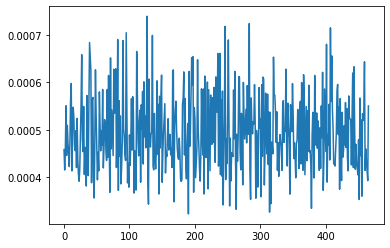

In [25]:
from matplotlib.pyplot import *
loss_list = []
for i in range(1, int(len(u_seq_test)/batch_size)):
        # u = u_seq[i]
        # y = y_seq[i]

        u = u_seq_test[i*batch_size:i*batch_size+batch_size]
        y = y_seq_test[i*batch_size:i*batch_size+batch_size]

        # 向前传播
        out = model(u.cuda())
    
        # 向后传播
        # optimizer.zero_grad() # 注意每次迭代都需要清零
        loss = criterion(out,y.cuda())
        loss_list.append(loss.cpu().detach().numpy())
        
        # loss.backward()
        # optimizer.step()
        # if i%100 == 0:
        #     pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss.item())})
plot(loss_list)

In [26]:
print(A)
print(model.A.weight)

tensor([[ 0.0673,  0.3651, -0.0044,  0.1481,  0.1211],
        [-0.6425, -0.0385, -0.2198, -0.3555, -0.1989],
        [-0.0981,  0.1217,  0.3485,  0.2783,  0.0231],
        [ 0.0677, -0.1976,  0.4526, -0.0326,  0.1223],
        [-0.1690,  0.0964,  0.1234, -0.0247, -0.1714]])
Parameter containing:
tensor([[-0.0937,  0.0823, -0.1812,  0.2875,  0.2578],
        [ 0.3145,  0.4350, -0.2330,  0.2905,  0.3376],
        [-0.1920,  0.7125, -0.2522, -0.0419, -0.1235],
        [-0.8737, -0.0136, -0.0604,  0.0376, -0.0568],
        [ 0.3368,  0.2345,  0.2006, -0.0973,  0.0764]], device='cuda:0',
       requires_grad=True)
